# Question 3: Data Pipeline and Transformation

Objective:
- Show understanding of creating data pipelines and transformations.

Task:
- Using the CSV file from Question 1, filter the data to include only 'Copper' and 'Zinc' for the year 2020 & 2021.
- Calculate MACD (slow/medium/fast) and RSI for each metal historically.
- Use SQL inserts to populate the SQL table created in Question 2 with this generated data.
- Demonstrate the use of a decorator to log the execution of the SQL inserts.

# Solution

For this question I used the following references for the definition of MACD and RSI, and assumptions on the value of the parameters:
- [MACD](https://www.investopedia.com/terms/m/macd.asp#toc-what-is-macd): calculated by subtracting the long-term exponential moving average (EMA) over 26 periods from the short-term EMA over 12 periods. The parameters 26 and 12 are traditionally used as default values, but they can be modified to optimise the desired temporal sensitivity.
- [RSI](https://en.wikipedia.org/wiki/Relative_strength_index#General_definitions): using the definition developed by J. Welles Wilder, calculates the Relative Strenght (RS) of a time series by looking at the EMA of the gains/losses, to then obtain the index as RSI = 100-100/(1+RS). The standart value for the RS smoothing is usually 14.

Given that these indicators use exponential moving averages, the first values of the MACD and RSI will have a bias from the lack of history. For this reason I select an initial padding before the dates of interest (years 2020 and 2021). To decide how much padding is needed, I calculated how many historical periods I need to include before their price is weighted less than 1% of the total weights. Given the recursivness of EMA it is easy to see that the value of the EMA at time 't' is:

$$
EMA(t) = \alpha * Price(t) + \sum_{i=1}^N\alpha*(1-\alpha)^i * Price(t-i)
$$

And I found N such that:

$$
\alpha * (1-\alpha)^N < 0.01
$$

I could see that for different values of k-periods N plateous around 35 (plot below). Therefore, it is reasonable to always pad the time-series of interest with 50 days of historical data. 

In [ ]:
import os
from datetime import timedelta
import sqlite3
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = f'{os.pardir}/data/MarketData.csv'

metals = ['COPPER', 'ZINC']

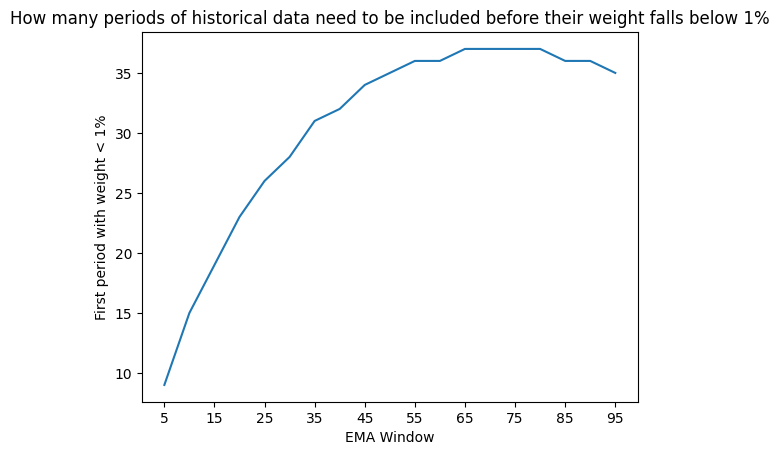

In [108]:
# Calculate how many days of padding I need to calculate an accurate EMA
precision = 0.01 # Weight smaller than 5%
paddings = []
for ema_window in np.arange(5, 100, 5):
    N_padding = int(np.ceil(np.log((ema_window + 1) * (precision / 2)) / np.log((ema_window - 1) / (ema_window + 1))))
    paddings.append(N_padding)

plt.plot(np.arange(5, 100, 5), paddings)
plt.xticks(np.arange(5, 100, 10))
plt.xlabel('EMA Window')
plt.ylabel('First period with weight < 1%')
plt.title('How many periods of historical data need to be included before their weight falls below 1%')
plt.show()

In [109]:
# Load the data 
raw_df = pd.read_csv(data_path)
raw_df

,Start Date,01/01/2010,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,End Date,01/01/2023,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,LME COPPER 3MO ($),LME ALUMINUM 3MO ($),LME ZINC 3MO ($),LME LEAD 3MO ($),LME TIN 3MO ($),Generic 1st 'CL' Future
3,NaN,LMCADS03 Comdty,LMAHDS03 Comdty,LMZSDS03 Comdty,LMPBDS03 Comdty,LMSNDS03 Comdty,CL1 Comdty
4,NaN,Settlement Price,Settlement Price,Settlement Price,Settlement Price,Settlement Price,Settlement Price
...,...,...,...,...,...,...,...
3392,26/12/2022,8349.5,2389.5,2965,2273.5,23934,79.56
3393,27/12/2022,8349.5,2389.5,2965,2273.5,23934,79.53
3394,28/12/2022,8443,2381,3005.5,2218,24734,78.96
3395,29/12/2022,8418,2405,2984.5,2272.5,24915,78.4


In [110]:
# Get columns names with metals
columns_metals = raw_df.iloc[2, 1:-1].values
columns_metals = [col.split(' ')[1] for col in columns_metals]
# Get the mask of the columns to select, the first column is the date
mask_columns = np.concatenate(([True], np.isin(columns_metals, metals), [False]))

# Select only Dates, Copper, and Zinc columns, the first 6 rows are other information
df = raw_df.iloc[6:, mask_columns].copy() # TODO: do this by using the column names
df.columns = np.concatenate((['Dates'], metals))
# Ensure the data types are correct. the format dd/mm/yyyy works better for pandas, but needs to be converted to yyyy-mm-dd in the database
df['Dates'] = pd.to_datetime(df['Dates'], format='%d/%m/%Y', errors='coerce')
for metal in metals:
    df[metal] = pd.to_numeric(df[metal], errors='coerce')
# Select only 2020 and 2021 with a padding at the beginning
start_date = pd.to_datetime('01/01/2020')
end_date = pd.to_datetime('31/12/2021')
# Use a padding to calculate the EMA and RSI without a starting bias
padding = 50
cutoff_date = start_date - timedelta(days=padding)
df = df[(df['Dates'] > cutoff_date) & (df['Dates'] <= end_date)]
print(df.isna().sum())
df

Dates     0
COPPER    0
ZINC      0
dtype: int64


/var/folders/vh/pvb88dx50v11x630t4hkqcpr0000gq/T/ipykernel_53414/1497143034.py:16: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  end_date = pd.to_datetime('31/12/2021')


,Dates,COPPER,ZINC
2579,2019-11-13,5835.0,2422.0
2580,2019-11-14,5812.0,2396.0
2581,2019-11-15,5849.0,2380.0
2582,2019-11-18,5830.0,2344.0
2583,2019-11-19,5875.0,2344.0
...,...,...,...
3132,2021-12-27,9568.0,3519.0
3133,2021-12-28,9568.0,3519.0
3134,2021-12-29,9680.5,3513.0
3135,2021-12-30,9691.5,3532.5


In [ ]:
# Calculate the MACD for Copper and Zinc

def calculate_MACD(time_data, short_window=12, long_window=26):
    """Calculate the Moving Average Convergence Divergence (MACD) for a given time series.
    INPUTS:
    - data: pd.Series, the time series data 
    - short_window, long_window: int, the short and long window periods for MACD line (EMA_short - EMA_long).
    OUTPUTS:
    - macd: pd.Series, as per definition
    """
    short_EMA = time_data.ewm(span=short_window, adjust=False).mean()
    long_EMA = time_data.ewm(span=long_window, adjust=False).mean()
    return short_EMA - long_EMA

def calculate_RSI(time_data, window=14):
    """Calculate the Relative Strength Index (RSI) for a given time series.
    The Relative Strenght (RS) is a EMA of the gains and losses with smoothing factor based on 'window'.
    INPUTS:
    - data: pd.Series, the time series data 
    - window: int, the window period for RSI
    OUTPUTS:
    - rsi: pd.Series, as per definition
    """
    delta = time_data.diff()
    gain = delta.where(delta > 0, other=0)
    loss = -delta.where(delta < 0, other=0) 
    avg_gain = gain.ewm(com=window).mean()
    avg_loss = loss.ewm(com=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

for metal in metals:
    df[f'MACD_{metal}'] = calculate_MACD(df[metal])
    df[f'RSI_{metal}'] = calculate_RSI(df[metal])

df

In [112]:
# Open a connection to the database
conn = sqlite3.connect(f'{os.pardir}/market_data.db')
cur = conn.cursor()

# Add MACD column to the database
try:
    cur.execute('''
        ALTER TABLE MetalPrices
        ADD COLUMN MACD REAL DEFAULT NULL;
    ''')
except sqlite3.OperationalError as e:
    if 'duplicate column name' in str(e):
        print("Column MACD already exists.")
    else:
        raise
# Add RSI column to the database
try:
    cur.execute('''
        ALTER TABLE MetalPrices
        ADD COLUMN RSI REAL DEFAULT NULL;
    ''')
except sqlite3.OperationalError as e:
    if 'duplicate column name' in str(e):
        print("Column RSI already exists.")
    else:
        raise

conn.commit()
cur.close()
conn.close()

In [113]:
def log_execution(func):
    def wrapper(*args, **kwargs):
        if func.__name__=='update_metal_indicators':
            print(f"Updating metal indicators for {args[1]} from {args[2]} to {args[3]}.")
        else:
            print(f"Running function {func.__name__} with arguments: {args} and keyword arguments: {kwargs}.")
        start_execution = time.time()
        result = func(*args, **kwargs)
        end_execution = time.time()
        print(f"Finished execution of {func.__name__} in {end_execution - start_execution:.2f} seconds.\n")
        return result
    return wrapper

@log_execution
def update_metal_indicators(df, metal, start_date, end_date):
    # Connect to the database
    conn = sqlite3.connect(f'{os.pardir}/market_data.db')
    cur = conn.cursor()

    # Select only dates of iterest
    df_filtered = df[(df['Dates'] >= start_date) & (df['Dates'] <= end_date)]

    # Loop through rows and update MACD and RSI for the specified metal
    for _, row in df_filtered.iterrows():
        # Convert the date to ISO format (YYYY-MM-DD)
        date_str = row['Dates'].strftime('%Y-%m-%d')
        
        cur.execute('''
            UPDATE MetalPrices
            SET MACD = ?, RSI = ?
            WHERE Date = ? AND Metal = ?;
        ''', (row[f'MACD_{metal}'], row[f'RSI_{metal}'], date_str, metal))

    # Commit the changes and close the connection
    conn.commit()
    cur.close()
    conn.close()

for metal in metals:
    update_metal_indicators(df, metal, start_date, end_date)

Updating metal indicators for COPPER from 2020-01-01 00:00:00 to 2021-12-31 00:00:00.
Finished execution of update_metal_indicators in 0.04 seconds.

Updating metal indicators for ZINC from 2020-01-01 00:00:00 to 2021-12-31 00:00:00.
Finished execution of update_metal_indicators in 0.02 seconds.

